# Practicing Feedback Control

In this unit we are going to explore basic feedback control on a highly simplified, 1-dimensional model of the quadrotor-camera system.

## Simple Slide Camera

Imagine a camera attached to a cart that is allowed to slide along a 1-dimensional track. The track is elevated some height $h$ above the ground and the camera is pointing downward. There is some target on the ground that the camera can observe; more specifically the camera can measure the angle $-\pi /2 < \gamma < \pi/2$ from the centerline of the camera to the target. The objective is to issue velocity commands, $v_{cmd}$, in order to move the cart to a position such that $\gamma \rightarrow \gamma_{des}$ (e.g. if $\gamma_{des} = 0$, then the objective is simply to move the cart directly over the target.

This system is depicted in the below diagram:

<img src="files/simple_slide_camera.jpg">

This somewhat contrived system can be thought of as a highly simplified model of the quadrotor and it's downward-facing camera. If the quadrotor is constrained to move in one dimension, can be controlled via velocity commands, and we ignore the pitch that is induced when changing velocity (valid assumption for low-acceleration maneuvers), then we can roughly model the quadrotor as this simple slide camera

Note that the position of the cart, $x$, and position of the target $x_{des}$ are not directly measured, only $\gamma$ is measured.

Now we will provide the code necessary to simulate this system

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

_HEIGHT = 1.0
_VEL_CONST = 1.0
_TIME_STEP = 0.1

## Plant Dynamics, Sensors, and Actuators

the following object contains functions for the plant dynamics, sensing of the target angle $\gamma$, and actuator for $v_{cmd}$

In [2]:
class SimpleSlideCamera():
    '''Object that defines the dynamics of the simple slide-camera'''
    
    def __init__(self, x_0, v_0, x_d, gamma_d=0.0, h=_HEIGHT):
        
        # state variables (hidden)
        self.__x = x_0
        self.__v = v_0
        
        # reference position (hidden)
        self.__x_d = x_d
        
        # reference angle (observed)
        self.gamma_d = gamma_d
        
        # parameters
        self.__h = h
        
    def sense_gamma(self):
        # calculate angle from camera center line to target
        return  np.arctan2(self.__x - self.__x_d, self.__h)
    
    def _get_hidden_position(self):
        
        return self.__x
    
    def _get_hidden_position_desired(self):
        return self.__x_d
    
    def _get_hidden_velocity(self):
        return self.__v
    
    def actuate_velocity_command(self, vel_cmd, dt=_TIME_STEP):
        self.__v = vel_cmd
        self.__x += self.__v*dt
        
    def actuate_disturbed_velocity_command(self, vel_cmd, dt=_TIME_STEP, vel_bias=0.5, vel_std=0.1):
        self.__v = vel_cmd + np.random.normal(vel_bias, vel_std)
        self.__x += self.__v*dt
        
    def actuate_acceleration_command(self, acc_cmd, dt=_TIME_STEP):
        self.__v += acc_cmd*dt
        self.__x += self.__v*dt 

## Controller

In [3]:
def p_control(y_err, kp):
    ''' compute the actuator command based on proportional error between output and desired output
    Args:
     y_err: y_des - y where y is the output variable of the plant
    Returns:
     cmd: actuator command to correct error (e.g. velocity command)
    '''
    
    # TODO: write a proportional control law (hint: it is a single line, very simple equations)
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    return kp * y_err

In [4]:
# p_control tests
assert np.isclose(p_control(0.0, 1.0), 0.0)
assert np.isclose(p_control(1.0, 1.0), 1.0)
assert np.isclose(p_control(-10.0, 0.1), -1.0)

## Simulation Script

below is a script for testing various controllers for the `SimpleSlideCamera` plant as well as plotting the results.

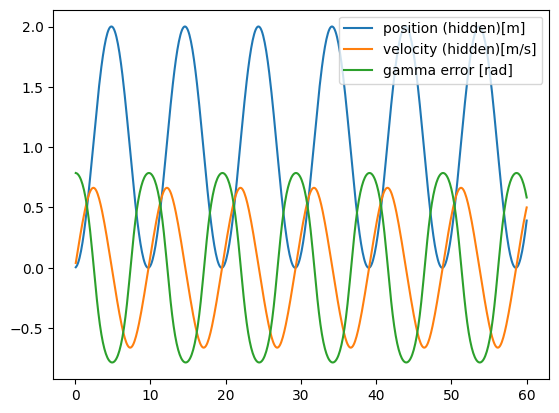

In [51]:
# Proportional gain
# TODO: assign an appropriate value to kp
# YOUR CODE HERE
# raise NotImplementedError()
kp = 0.5


# Control inputs
dt = _TIME_STEP
t_final = 60.0

# intial conditions (position, velocity and targe position)
x_0 = 0.0
v_0 = 0.0
x_des = 1

# create SimpleSlideCamera with initial conditions
sscam = SimpleSlideCamera(x_0, v_0, x_des)

# initialize data storage
data = dict()
data['t'] = []
data['acc_cmd'] = []
data['vel_cmd'] = []
data['err_gamma'] = []
data['x_hidden'] = []
data['v_hidden'] = []
t = 0.0
err_prev = 0.0
while t < t_final:
    t += dt
    
    # SENSOR: sense output variable gamma (angle from camera centerline to target) and calculate error from desired
    err_gamma = sscam.gamma_d - sscam.sense_gamma()
    
    # CONTROLLER: call velocity control algoritm
    vel_cmd = p_control(err_gamma, kp)
    
    # ACTUATOR: send velocity command to plant
    sscam.actuate_acceleration_command(vel_cmd)
    
    # store data
    err_gamma_prev = err_gamma
    data['t'].append(t)
    data['vel_cmd'].append(vel_cmd)
    data['err_gamma'].append(err_gamma)
    data['x_hidden'].append(sscam._get_hidden_position())
    data['v_hidden'].append(sscam._get_hidden_velocity())
    
# Plot Data
handle_position, = plt.plot(data['t'], data['x_hidden'], label='position (hidden)[m]')
handle_velocity, = plt.plot(data['t'], data['v_hidden'], label='velocity (hidden)[m/s]')
handle_err_gamma, = plt.plot(data['t'], data['err_gamma'], label='gamma error [rad]')
plt.legend(handles=[handle_position, handle_velocity, handle_err_gamma])
plt.show()

## Questions

__Q1.__ Does your gamma error (i.e. output converge to 0.0? 
    - If so how quickly (i.e. how long does it take for the error to be 5% of the original error)
    - If not, what is happening? Is the error never changing or is it oscillating back and forth across zero? Can you change the proportional gain kp to change this behavior?


Yeah - under the condition $k_p=0.9$ and $t_{max}=60$, we can have the gamma error converges to $0.0$ at about $t'=10.0s$. If our $k_p$ is too small (like $0.01$), the gamma error will not converge in a short period of time; if our $k_p$ is too large (like $40$), the gamma error and velocity will be constantly oscillating.


__Q2.__ What values should your system's position and velocity be converging upon? Since this is a practice problem and we want to gain understanding of how this system behaves, we've cheated and let you observe the position and velocity of the system which were meant to be unobservable in the real world. Are the position and velocity converging to values you expected?


When taking $k_p=0.9$, the system's position is converging upon $10m$ and the velocity is converging upon $0m/s$, which are both the desired values that we expect to reach.

__Q3.__ As you increase the proportional gain, what happens to the rate at which the error converges to zero? 

Can you find a proportional gain that converges within 1 second (i.e error reaches 5% of it's original value)? Note: if you start to see an oscillatory, saw-tooth pattern, you're gain is too high.


If we increase the proportional gain, the rate of error's convergence will be increased as well. However, if the proportional gain is too high, we will just have the speed and error to be oscilating at certain degree.

The proportional gain to make the drone converges within $1$ second (under $y_{des}=10.0m$), we will need a $k_p$ of $10$. The value can't be too small as it makes the error to converge slower, and it can't be too large as that's causing the oscillation.

__Q4.__ What happens if you cannot perfectly control the velocity, for example there is some form of velocity disturbance that you cannot control (e.g. wind, actuator noise)? Let's try it out:

In the #ACTUATOR portion of the simulation script, replace `actuate_velocity_command` with `actuate_disturbed_velocity_command`, restart the kernel, and run the script. Does output error (gamma error) still converge to zero? If not, what does the gamma error converge to? How might you change your controller to fix this "steady state error"

The gamma error will no longer converge to $0$ this time. It tends to converge to somewhere equals to the value of the average wind speed (I set it as $1.0m/s$) in this case.

__Q5.__ Often times we control a system by applying a force. In this way we are not directly controlling the velocity of a system, but instead the acceleration. Let's try it out:

In the ACTUATOR portion of the simulation script replace `actuate_velocity_command` with `actuate_acceleration_command`. In the CONTROLLER portion of the script, have the controller output a acc_cmd instead of vel_cmd (just change the variable name, but this way you know it represents an acceleration instead of a velocity). Restart the kernel and rerun the script

Now what is happening to the gamma error, is it converging to zero? If not, is there anything you could think of to change in you controller in order to converge the error to zero?

The gamma error is no longer converging to $0$ in this case. Instead, the error, velocity, and height all have shown an oscillation feature. When taking $y_{des}=1.0m$, the height is oscillating between $0.0m$ and $2.0m$ - reasonably believe the range of oscillation should be between $0.0m$ and $2y_{des}$.